In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
import os
import tqdm

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2


In [2]:
from simulate import covariate_creator, simulate_and_censor, covariate_extend, binary_to_continous2
from lifelines import KaplanMeierFitter, CoxPHFitter


# Diamond structure for var1 and var2 

We will create a function that will return two classes depending on the values of var1 and var2

In [3]:
def inverse_phi(return_phi = 0, create_random = 100000, n_sample = 1, seed = 42):
    
    np.random.seed(seed=seed)
    
    #Create a diamond structure
    x3_x4 = np.random.uniform(low = -2.0, high = 2.0, size = (create_random,2))
    phi = np.int0(np.abs(x3_x4).sum(axis = 1) > 2)
    
    df = pd.DataFrame(x3_x4)
    df.columns =['x3', 'x4']
    df['phi'] = phi
    
    df_phi = df[df['phi'] == return_phi]
    
    # Select randomly some n points
    return df_phi[['x3','x4']].sample(n = n_sample)
    

In [22]:
# Create two different distributions of 100K points, sample only 5000 points from each
tmp0 = inverse_phi(0, 100000, 5000, 42)
tmp1 = inverse_phi(1, 100000, 5000, 43)

# Assign the corresponding values for the distributions
tmp0['var1'] = 0
tmp1['var1'] = 1

#Concatenate and shuffle
tmp = pd.concat([tmp0, tmp1])
tmp = tmp.sample(frac = 1)
tmp = tmp.reset_index(drop = True)


In [23]:
tmp


,x3,x4,var1
0,1.799975,-1.311070,1
1,-1.056208,0.048323,0
2,1.344553,1.727553,1
3,-1.576667,0.775300,1
4,-0.677828,-0.256139,0
...,...,...,...
9995,1.162027,1.176774,1
9996,-1.306456,-0.713288,1
9997,-0.597191,-1.132969,0
9998,-1.645974,1.280448,1


We can visualize the 10K samples as follow:

<Axes: xlabel='x3', ylabel='x4'>

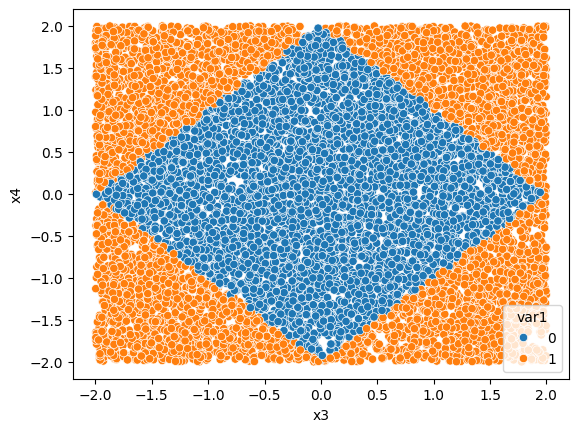

In [6]:
sns.scatterplot(data=tmp, x = 'x3', y = 'x4', hue = 'var1')


Now create a dataset with 10K samples, with 5 fully random variables of different prevalences

In [8]:
X = covariate_creator(means = [0,0,0,0,0], binarize=True, seed=0, size=10000, p = [0.75, 0.6, 0.4, 0.3, 0.75])


In [9]:
X


,trt,var1,var2,var3,var4,var5
0,1,0,1,0,0,0
1,1,1,1,0,0,1
2,1,1,1,0,0,1
3,1,1,1,0,1,1
4,0,1,1,0,1,1
...,...,...,...,...,...,...
9995,1,1,0,1,1,0
9996,0,1,1,0,0,1
9997,1,1,1,0,0,1
9998,0,1,1,0,0,1


# Replace var1 from the one created with the diamond

var1 encodes de "predictive biomarker", derived from the two columns (x3 and x4)

In [10]:
X.loc[:,'var1'] = tmp['var1']


# Extend X

We create all the cross product variables (trt x var_N) need for the simulation

In [11]:
X = covariate_extend(X)


# Simulate 

In [12]:
seed=1948
gam=1.5
lamb=0.07

censoring_ratio = 0.000
normalize_to_time = -64
recruiting_timeframe = 18
administrative_date = -48

betas = [np.log(1.1), # 1 trt
     np.log(1.0), 0.0, 0.0, 0.0, 0.0, # 5 vars
     np.log(0.6), 0.0, 0.0, 0.0, 0.0, # 5 vars x trt
     0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, # 10 var_i x var_j
     0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,] #10 trt x var_i x var_j

df = simulate_and_censor(X, betas, gam, lamb, censoring_ratio, normalize_to_time,
                       recruiting_timeframe, administrative_date, seed)

df = df[['trt','var1','var2','var3','var4','var5','observed_t','event']].copy()
df = binary_to_continous2(df, ['var1','var2','var3','var4','var5'])


In [13]:
df


,trt,var1,var2,var3,var4,var5,observed_t,event
0,1,0.164658,0.060121,-0.543706,-0.690243,-0.036212,6.174144,1
1,1,-0.202885,0.551677,-0.499105,-0.199397,0.109097,6.128794,1
2,1,0.474311,0.440183,-0.463950,-0.068852,0.438342,2.162109,1
3,1,0.326355,0.590411,-0.128757,0.226072,0.554176,4.406717,1
4,0,-0.390776,0.309376,-0.132844,0.209360,0.059755,7.185644,1
...,...,...,...,...,...,...,...,...
9995,1,0.372791,-0.292463,0.319639,0.080695,-0.227824,1.531602,1
9996,0,0.178022,0.418031,-0.439034,-0.146307,0.115575,6.676482,1
9997,1,-0.475734,0.561791,-0.323133,-0.478970,0.591364,1.927192,1
9998,0,0.146510,0.249065,-0.507108,-0.578556,0.486630,3.049397,1


# Replace var1 and var2 for the x3 and x4 of the diamond. Add again var1 from the diamond as vard

Now we want to hide the nature of the predictive biomarker, replacing using x3 and x4 which encodes the predictive biomarker var1. We will rename var1 as vard to keep track of the "predictive" nature, but we will not use it for modelling.m

In [14]:
df.loc[:,'var1'] = tmp['x3']
df.loc[:,'var2'] = tmp['x4']
df['vard'] = tmp['var1']


In [15]:
df


,trt,var1,var2,var3,var4,var5,observed_t,event,vard
0,1,1.799975,-1.311070,-0.543706,-0.690243,-0.036212,6.174144,1,1
1,1,-1.056208,0.048323,-0.499105,-0.199397,0.109097,6.128794,1,0
2,1,1.344553,1.727553,-0.463950,-0.068852,0.438342,2.162109,1,1
3,1,-1.576667,0.775300,-0.128757,0.226072,0.554176,4.406717,1,1
4,0,-0.677828,-0.256139,-0.132844,0.209360,0.059755,7.185644,1,0
...,...,...,...,...,...,...,...,...,...
9995,1,1.162027,1.176774,0.319639,0.080695,-0.227824,1.531602,1,1
9996,0,-1.306456,-0.713288,-0.439034,-0.146307,0.115575,6.676482,1,1
9997,1,-0.597191,-1.132969,-0.323133,-0.478970,0.591364,1.927192,1,0
9998,0,-1.645974,1.280448,-0.507108,-0.578556,0.486630,3.049397,1,1


We can check that there is no correlation between the variables

In [16]:
df[['var1','var2','var3','var4','var5']].corr()


,var1,var2,var3,var4,var5
var1,1.000000,0.008062,0.005818,0.010490,0.018269
var2,0.008062,1.000000,0.004473,-0.004911,0.001249
var3,0.005818,0.004473,1.000000,0.004892,-0.012388
var4,0.010490,-0.004911,0.004892,1.000000,-0.006729
var5,0.018269,0.001249,-0.012388,-0.006729,1.000000


Now, let's check if evertyhing worked as expected. If we use vard values, we should expect a predictive behavior.

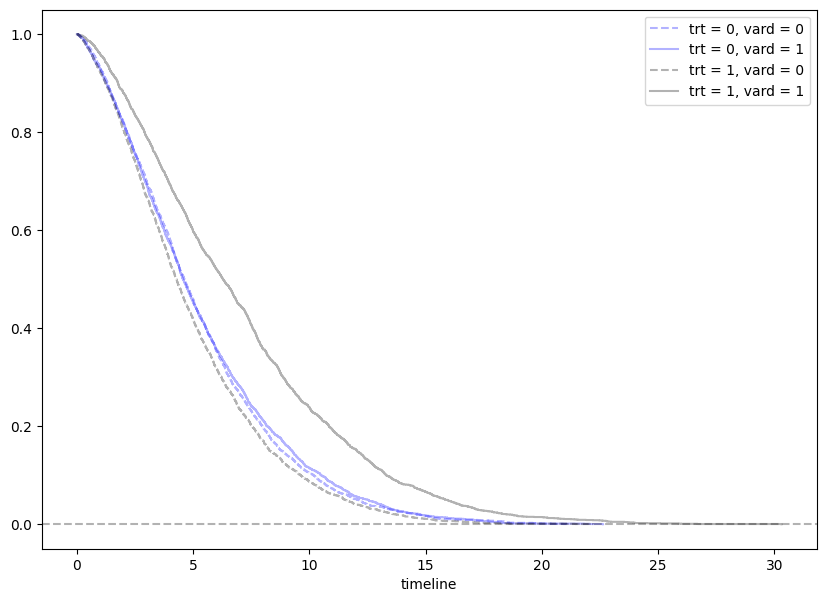

In [25]:
k = 'vard'
# plot
fig, ax = plt.subplots(1, figsize = (10, 7))

kmf = KaplanMeierFitter()

tmp = df.query('trt == 0').query('{}  <= 0'.format(k))
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=True, ci_show = False, ax = ax, color = 'blue', alpha = 0.3, label = 'trt = 0, vard = 0', ls = '--')

tmp = df.query('trt == 0').query('{} > 0'.format(k))
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=True, ci_show = False, ax = ax, color = 'blue', alpha = 0.3, label = 'trt = 0, vard = 1')

tmp = df.query('trt == 1').query('{} <= 0'.format(k))
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=True, ci_show = False, ax = ax, color = 'black', alpha = 0.3, label = 'trt = 1, vard = 0', ls = '--')

tmp = df.query('trt == 1').query('{} > 0'.format(k))
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=True, ci_show = False, ax = ax, color = 'black', alpha = 0.3, label = 'trt = 1, vard = 1')

plt.axhline(0, color = 'k', ls ='--', alpha = 0.3)


If we use only var1, we will not observe it.

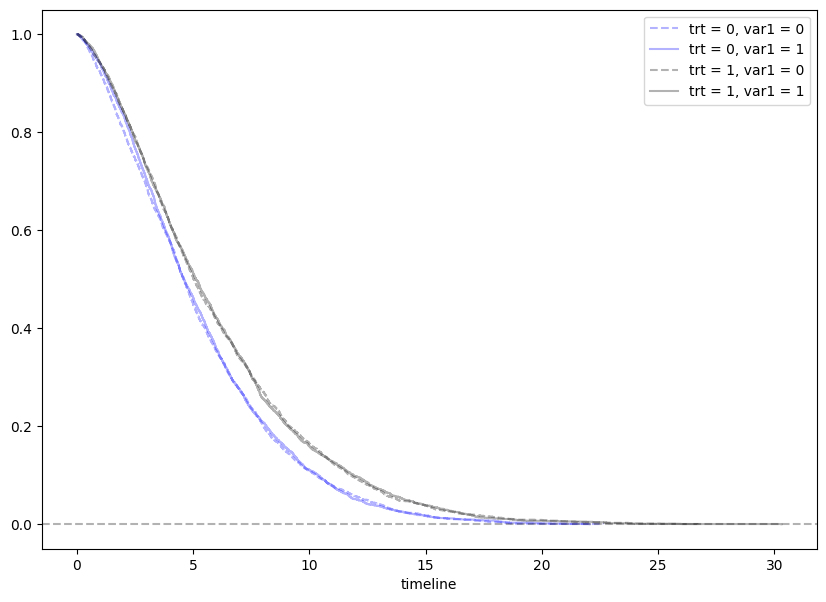

In [28]:
k = 'var1'
# plot
fig, ax = plt.subplots(1, figsize = (10, 7))

kmf = KaplanMeierFitter()

tmp = df.query('trt == 0').query('{}  <= 0'.format(k))
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=True, ci_show = False, ax = ax, color = 'blue', alpha = 0.3, label = 'trt = 0, {} = 0'.format(k), ls = '--')

tmp = df.query('trt == 0').query('{} > 0'.format(k))
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=True, ci_show = False, ax = ax, color = 'blue', alpha = 0.3, label = 'trt = 0, {} = 1'.format(k))

tmp = df.query('trt == 1').query('{} <= 0'.format(k))
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=True, ci_show = False, ax = ax, color = 'black', alpha = 0.3, label = 'trt = 1, {} = 0'.format(k), ls = '--')

tmp = df.query('trt == 1').query('{} > 0'.format(k))
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=True, ci_show = False, ax = ax, color = 'black', alpha = 0.3, label = 'trt = 1, {} = 1'.format(k))

plt.axhline(0, color = 'k', ls ='--', alpha = 0.3)


same for var2

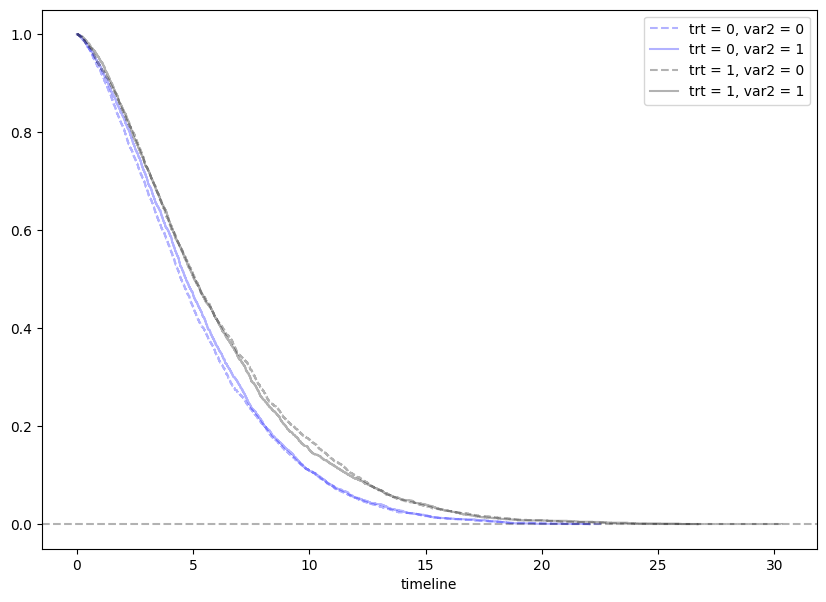

In [29]:
k = 'var2'
# plot
fig, ax = plt.subplots(1, figsize = (10, 7))

kmf = KaplanMeierFitter()

tmp = df.query('trt == 0').query('{}  <= 0'.format(k))
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=True, ci_show = False, ax = ax, color = 'blue', alpha = 0.3, label = 'trt = 0, {} = 0'.format(k), ls = '--')

tmp = df.query('trt == 0').query('{} > 0'.format(k))
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=True, ci_show = False, ax = ax, color = 'blue', alpha = 0.3, label = 'trt = 0, {} = 1'.format(k))

tmp = df.query('trt == 1').query('{} <= 0'.format(k))
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=True, ci_show = False, ax = ax, color = 'black', alpha = 0.3, label = 'trt = 1, {} = 0'.format(k), ls = '--')

tmp = df.query('trt == 1').query('{} > 0'.format(k))
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=True, ci_show = False, ax = ax, color = 'black', alpha = 0.3, label = 'trt = 1, {} = 1'.format(k))

plt.axhline(0, color = 'k', ls ='--', alpha = 0.3)


and for any of the random variables

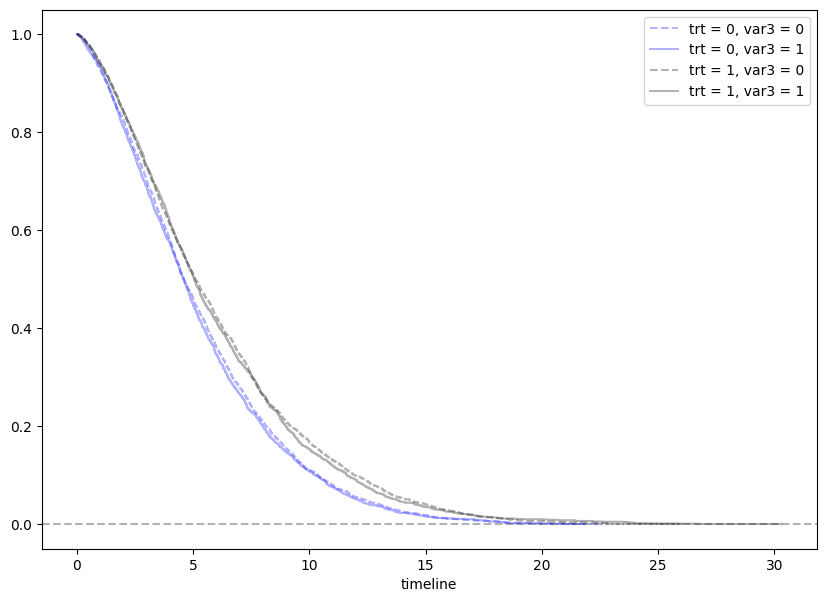

In [30]:
k = 'var3'
# plot
fig, ax = plt.subplots(1, figsize = (10, 7))

kmf = KaplanMeierFitter()

tmp = df.query('trt == 0').query('{}  <= 0'.format(k))
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=True, ci_show = False, ax = ax, color = 'blue', alpha = 0.3, label = 'trt = 0, {} = 0'.format(k), ls = '--')

tmp = df.query('trt == 0').query('{} > 0'.format(k))
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=True, ci_show = False, ax = ax, color = 'blue', alpha = 0.3, label = 'trt = 0, {} = 1'.format(k))

tmp = df.query('trt == 1').query('{} <= 0'.format(k))
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=True, ci_show = False, ax = ax, color = 'black', alpha = 0.3, label = 'trt = 1, {} = 0'.format(k), ls = '--')

tmp = df.query('trt == 1').query('{} > 0'.format(k))
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=True, ci_show = False, ax = ax, color = 'black', alpha = 0.3, label = 'trt = 1, {} = 1'.format(k))

plt.axhline(0, color = 'k', ls ='--', alpha = 0.3)


We can recheck the condition of the biomarker as:

In [38]:
df.query('abs(var1) + abs(var2) > 2')


,trt,var1,var2,var3,var4,var5,observed_t,event,vard
0,1,1.799975,-1.311070,-0.543706,-0.690243,-0.036212,6.174144,1,1
2,1,1.344553,1.727553,-0.463950,-0.068852,0.438342,2.162109,1,1
3,1,-1.576667,0.775300,-0.128757,0.226072,0.554176,4.406717,1,1
5,1,-1.173230,1.083829,-0.182597,-0.681564,0.066859,6.640666,1,1
6,0,1.257514,-1.655992,-0.291585,-0.683773,0.547327,3.895530,1,1
...,...,...,...,...,...,...,...,...,...
9990,1,-0.742726,1.309439,0.283126,0.094764,0.502496,10.851331,1,1
9991,0,1.854525,0.720767,-0.482953,-0.640748,0.287237,5.849900,1,1
9995,1,1.162027,1.176774,0.319639,0.080695,-0.227824,1.531602,1,1
9996,0,-1.306456,-0.713288,-0.439034,-0.146307,0.115575,6.676482,1,1


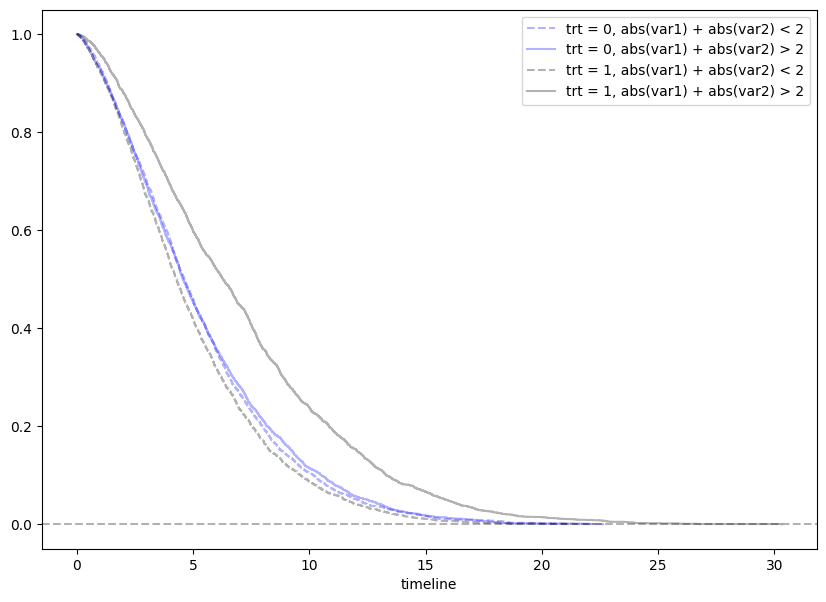

In [44]:
k1 = 'abs(var1) + abs(var2) > 2'
k2 = 'abs(var1) + abs(var2) < 2'
# plot
fig, ax = plt.subplots(1, figsize = (10, 7))

kmf = KaplanMeierFitter()

tmp = df.query('trt == 0').query('{}'.format(k2))
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=True, ci_show = False, ax = ax, color = 'blue', alpha = 0.3, label = 'trt = 0, {}'.format(k2), ls = '--')

tmp = df.query('trt == 0').query('{}'.format(k1))
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=True, ci_show = False, ax = ax, color = 'blue', alpha = 0.3, label = 'trt = 0, {}'.format(k1))

tmp = df.query('trt == 1').query('{}'.format(k2))
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=True, ci_show = False, ax = ax, color = 'black', alpha = 0.3, label = 'trt = 1, {}'.format(k2), ls = '--')

tmp = df.query('trt == 1').query('{}'.format(k1))
kmf.fit(tmp['observed_t'], tmp['event'])
kmf.plot(show_censors=True, ci_show = False, ax = ax, color = 'black', alpha = 0.3, label = 'trt = 1, {}'.format(k1))

plt.axhline(0, color = 'k', ls ='--', alpha = 0.3)
